## IMPORTING LIBRARIES AND READING THE DATA

In [1]:
# IMPORTING LIBRARIES 
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from tensorflow.keras import datasets, layers,models
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, Activation
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras import regularizers
from sklearn.preprocessing import LabelEncoder
import warnings 
warnings.filterwarnings("ignore")
from sklearn.utils import class_weight
from sklearn.metrics import accuracy_score
import c_writer
from os.path import join

In [2]:
# reading the data
df = pd.read_csv("creditcard.csv")
#dropping time
df = df.drop(columns = ["Time"])
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## TESTING AND TRAINING OUR NEURAL NETWORK MODELS 

In [3]:
X = df.loc[:,df.columns!="Class"].to_numpy()
X = X/X.max(axis=0) #normalising
Y = df.loc[:,df.columns=="Class"].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20)

In [6]:
# Getting input and output layer dimensions
input_dim = X_train.shape[1]
output_dim = y_train.shape[1]
# To store the accuracies of the two models to later find which model is better for our project
model_acc = []
our_models = []

In [26]:

def NN_model(X_train,X_test,y_train,y_test):
        # Sequential model with 3 layers
        model = tf.keras.models.Sequential([
        Dense(units = 16, input_shape =(input_dim,),activation = 'relu'),
        Dense(units = 16, activation = 'relu'),
        Dense(units = 2, activation = 'softmax')])
        # compiling and fitting the model with  optimizer and categorical cross entropy loss
        model.compile(optimizer = "adam", loss = "sparse_categorical_crossentropy")
        model.fit(x = X_train, y = y_train, epochs = 10, shuffle = True)
        # Predicting
        prediction = model.predict(X_test)
        # Since it gives the probaility of the class, the class with the max probability is our prediction
        y_pred = np.argmax(prediction,axis = -1)
        conf_matrix = confusion_matrix(y_test, y_pred)
        ax = sns.heatmap(conf_matrix, annot=True, fmt="d")
        # The top and bottom of heatmap gets trimmed off so to prevent that we set ylim
        bottom, top = ax.get_ylim()
        ax.set_ylim(bottom + 0.5, top - 0.5)
        plt.title("Confusion matrix")
        plt.show()
        pred = y_pred.astype(int)
        print("ACCURACY")
         # Appending model accuracy and model object for later use
        model_acc.append(accuracy_score(y_test,pred))
        our_models.append(model)
        print(accuracy_score(y_test,pred))

In [33]:
# function definition for auto-encoder model
def autoen_model(X_train, X_test, y_train, y_test ):
    
    # encoding dimensions
    encoding_dim = 16
    input_layer = Input(shape=(input_dim, ))
    encoder = Dense(encoding_dim, activation ="tanh", activity_regularizer = regularizers.l1(1e-5))(input_layer)
    encoder = Dense(int(encoding_dim / 2), activation = "relu")(encoder)
    decoder = Dense(int(encoding_dim / 2), activation ='tanh')(encoder)
    decoder = Dense(output_dim, activation ='relu')(decoder)
    autoencoder = Model(inputs = input_layer, outputs=decoder)
    # no of epochs = number times that the learning algorithm will work through the entire training dataset.
    nb_epoch = 10
    # batch size
    b_size = 32
    # Configuring and compiling the model using adam optimizer (stochastic gradient descent method that is 
    # based on adaptive estimation of first-order and second-order moments) and mean_squared_error loss
    # (MSE is the sum of squared distances between our target variable and predicted values)
    autoencoder.compile(optimizer='adam',loss='mean_squared_error',metrics=['accuracy'])
    # Estimate sample weights by class for unbalanced datasets.
    cws = class_weight.compute_sample_weight("balanced", y_train)
    weight = {i : cws[i] for i in range(len(np.unique(y_train)))}
    # Fitting the model
    autoencoder.fit(X_train, y_train,class_weight = weight,epochs=nb_epoch,batch_size = b_size)
    # Predicting 
    predictions = autoencoder.predict(X_test)
    # Converting from float to int
    pred = predictions.astype(int)
    # Confusion matrix heatmap
    conf_matrix = confusion_matrix(y_test,pred)
    ax = sns.heatmap(conf_matrix, annot=True, fmt="d")
    # The top and bottom of heatmap gets trimmed off so to prevent that we set ylim
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    plt.title("Confusion matrix")
    plt.show()
    # Calculating root mean square error
    rmse = np.sqrt(np.mean(((pred - y_test) ** 2)))
    print("ROOT MEAN SQUARE ERROR")
    print(rmse)
    print("ACCURACY")
    # Appending model accuracy and model object for later use 
    model_acc.append(accuracy_score(y_test,pred))
    our_models.append(autoencoder)
    print(accuracy_score(y_test,pred))    

Epoch 1/10
7121/7121 [==============================] - 13s 1ms/step - loss: 0.0379
Epoch 2/10
7121/7121 [==============================] - 7s 1ms/step - loss: 0.0031
Epoch 3/10
7121/7121 [==============================] - 8s 1ms/step - loss: 0.0034
Epoch 4/10
7121/7121 [==============================] - 11s 2ms/step - loss: 0.0027
Epoch 5/10
7121/7121 [==============================] - 8s 1ms/step - loss: 0.0028
Epoch 6/10
7121/7121 [==============================] - 9s 1ms/step - loss: 0.0028
Epoch 7/10
7121/7121 [==============================] - 9s 1ms/step - loss: 0.0026
Epoch 8/10
7121/7121 [==============================] - 9s 1ms/step - loss: 0.0027
Epoch 9/10
7121/7121 [==============================] - 8s 1ms/step - loss: 0.0027
Epoch 10/10
7121/7121 [==============================] - 7s 1ms/step - loss: 0.0025


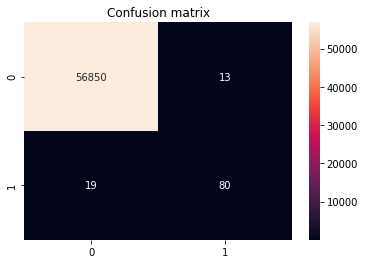

ACCURACY
0.9994382219725431


In [27]:
# calling the basic NN model for our testing and training data 
NN_model(X_train,X_test,y_train,y_test)

Epoch 1/10
7121/7121 [==============================] - 8s 798us/step - loss: 6.9042e-04 - accuracy: 0.9985
Epoch 2/10
7121/7121 [==============================] - ETA: 0s - loss: 2.6886e-04 - accuracy: 0.99 - 6s 797us/step - loss: 2.6910e-04 - accuracy: 0.9994
Epoch 3/10
7121/7121 [==============================] - 12s 2ms/step - loss: 2.7286e-04 - accuracy: 0.9995
Epoch 4/10
7121/7121 [==============================] - 18s 3ms/step - loss: 2.9952e-04 - accuracy: 0.9994
Epoch 5/10
7121/7121 [==============================] - 11s 2ms/step - loss: 2.8300e-04 - accuracy: 0.9994
Epoch 6/10
7121/7121 [==============================] - 10s 1ms/step - loss: 2.8970e-04 - accuracy: 0.9994
Epoch 7/10
7121/7121 [==============================] - 9s 1ms/step - loss: 3.0004e-04 - accuracy: 0.9993
Epoch 8/10
7121/7121 [==============================] - 11s 1ms/step - loss: 3.0089e-04 - accuracy: 0.9994
Epoch 9/10
7121/7121 [==============================] - 9s 1ms/step - loss: 2.5341e-04 - accuracy

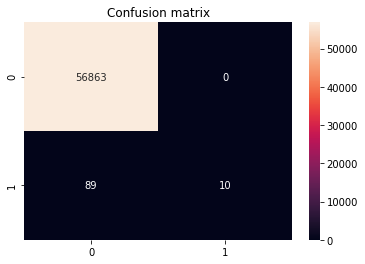

ROOT MEAN SQUARE ERROR
0.03952777680144061
ACCURACY
0.9984375548611355


In [34]:
#calling the auto encoder model for our testing and training data 
autoen_model(X_train,X_test,y_train,y_test)

In [36]:
# Model accuracies 
model_names = ["DNN","AUTOENCODER"]
df_acc = pd.DataFrame(list(zip(model_names,model_acc)))
df_acc.rename(columns = {0:'MODEL',1:'ACCURACY'},inplace=True)
df_acc

,MODEL,ACCURACY
0,DNN,0.999438
1,AUTOENCODER,0.998438


## TINYML

In [39]:
# getting best model object based off max accuracy
best_model = our_models[model_acc.index(max(model_acc))]
# Convert to tflite model
converter = tf.lite.TFLiteConverter.from_keras_model(best_model)
tflite_model = converter.convert()

# Save the model in .tflite format
with open('credit_model.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\deept\AppData\Local\Temp\tmpq7donn6s\assets


In [40]:
# Converting tflite_model to C  
# c_writer is a py file in the same folder and has been imported at the beginning of the notebook
# Reference : https://github.com/ShawnHymel/tinyml-example-anomaly-detection/blob/master/utils/c_writer.py
# Weuse #04x to pad the output to 2 digits with a 0x prefix
hex_array = [format(val, '#04x') for val in tflite_model]
# Calling function to convert an array into a C string (requires Numpy) 
# create_array(np_array, var_type, var_name, line_limit=80, indent=4)
c_model = c_writer.create_array(np.array(hex_array), 'unsigned char', "credit_model")
# Calling Function to create a header file with given C code as a string
header_str = c_writer.create_header(c_model, "credit_model")

In [41]:
#Writing to the header file
with open(join("C:\\Users\\deept\\Desktop\\Sem 4\\Sem4 Projects\\CN Project", "credit_model") + '.h', 'w') as file:
    file.write(header_str)

In [42]:
# Converting a sample piece of the X test and y test data to C (for the purpose of ino code (arduino) to load and test 
# the sample and compare with our python output

Xtest = X_test[0:5,:]
print(c_writer.create_array(Xtest,"float","X_test"))

const unsigned int X_test_dim1 = 5;
const unsigned int X_test_dim2 = 29;

const float X_test[5][29] = {
    -0.1767624871547712, -0.01257830042819834, 0.09114190496190434, 
    -0.08912739641492215, 0.01042116317795072, -0.018201231350455364, 
    -0.0013985528303141837, -0.0025675689506501603, -0.06984850801432883, 
    -0.012486267398158843, -0.0527996651191385, -0.14115349071151576, 
    0.005488000746610829, -0.1195799188488662, 0.025663161569303428, 
    0.10756798377236211, 0.05341646380481171, -0.17904065107569042, 
    0.0032208853773887493, 0.005208277357057328, -0.0009340940057964155, 
    -0.040428242008919105, 0.006459092411942691, -0.0534420146187649, 
    -0.05517488066317676, -0.19267304403864194, 0.0017475726872192502, 
    0.002876846161436283, 0.0005838584166693913, 0.03449496454499912, 
    -0.05980000659170307, 0.03501231570747203, -0.23155400162825598, 
    0.03846158501766525, 0.055650105961395004, -0.009947507184952202, 
    0.03819444726460856, -0.05413221479786

In [43]:
ytest=y_test[0:5]
print(c_writer.create_array(ytest,"uint8_t","y_test"))

const unsigned int y_test_dim1 = 5;
const unsigned int y_test_dim2 = 1;

const uint8_t y_test[5][1] = {
    0, 0, 0, 0, 0
};



## REFERENCES

### 1. https://www.kaggle.com/aaryanverma/anamoly-detection-with-82-accuracy-on-test-data/comments
### 2. https://eloquentarduino.github.io/2021/03/tinyml-classification-example-wine-dataset/
### 3. https://github.com/ShawnHymel/tinyml-example-anomaly-detection
### 4. TinyML: Machine Learning with TensorFlow Lite on Arduino and Ultra-Low-Power Microcontrollers